In [1]:
%load_ext autoreload
%autoreload 2

In [23]:
#| echo: false
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%config InlineBackend.figure_format = 'svg'
from tqdm.notebook import tqdm, trange

from genominterv.intervals import interval_collapse, interval_diff
from genominterv.remapping import remap_interval_data, remap
from genominterv.decorators import bootstrap
from statsmodels.distributions.empirical_distribution import ECDF
from genominterv.stats import jaccard_stat


## Testing

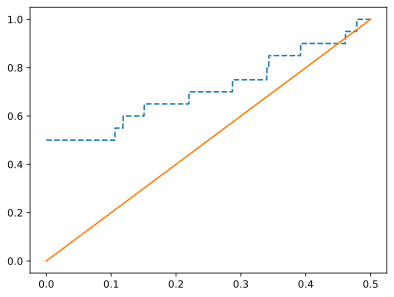

In [3]:
distances = [0]*10 + (np.random.random(10) / 2).tolist()
ecdf = ECDF(distances, side='right')
points = np.linspace(0, 0.5, 1000)
plt.plot(points, ecdf(points), linestyle='dashed')
plt.plot(points, 2 * points)

In [44]:


def random_intervals(chrom_len, n_segments, segment_len):
    a = np.sort(np.random.randint(1, chrom_len, size=n_segments))
    annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+segment_len))
    q = np.sort(np.random.randint(1, chrom_len, size=n_segments))
    query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+segment_len))
    annot = interval_collapse(annot)
    query = interval_collapse(query)
    return query, annot

def non_random_intervals(chrom_len, n_segments, segment_len):
    a = np.sort(np.random.randint(1, chrom_len, size=n_segments))
    annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+segment_len))
    q = a + np.random.randint(-5_000_000, 5_000_000, size=n_segments)
    query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+segment_len))
    annot = interval_collapse(annot)
    query = interval_collapse(query)
    return query, annot

@bootstrap('hg38', cores=8, samples=10000)
def proximity(q, a, overlap_as_zero=False, span_as_zero=False):
    remapped_df = remap_interval_data(q, a,                                       
                                      relative=True,
                                      overlap_as_zero=overlap_as_zero,
                                      span_as_zero=span_as_zero)
    if remapped_df.index.size == 0:
        return np.nan
    obs_ecdf = ECDF(remapped_df.start.abs())
    points = np.linspace(0, 0.5, num=1000)  
    test_stat = sum(obs_ecdf(points) - 2 * points) / len(points)
    return test_stat
    
@bootstrap('hg38', cores=8, samples=10000)
def mean_dist_test(q, a):
    remapped_df = remap_interval_data(q, a,                                       
                                      relative=True,
                                      overlap_as_zero=False,
                                      span_as_zero=False)
    return 0.5 - remapped_df.start.abs().mean()

@bootstrap('hg38', cores=8, samples=10000)
def median_dist_test(q, a):
    remapped_df = remap_interval_data(q, a,                                       
                                      relative=True,
                                      overlap_as_zero=False,
                                      span_as_zero=False)
    return 0.5 - remapped_df.start.abs().median()

@bootstrap('hg19', cores=8, samples=10000)
def jaccard_test(q, a):
    return jaccard_stat(q, a)


chrom_len, n_segments, segment_len = 150_000_000, 10, 1_000_000
records = []

/Users/kmt/genominterv/genominterv/intervals.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = label


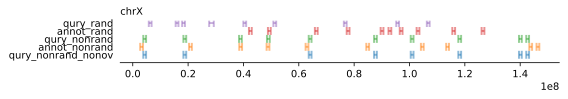

In [57]:

qury_rand, annot_rand = random_intervals(chrom_len, n_segments, segment_len)
qury_nonrand, annot_nonrand = non_random_intervals(chrom_len, n_segments, segment_len)
from genominterv.intervals import _plot_intervals
_plot_intervals(qury_rand=qury_rand, annot_rand=annot_rand, 
                qury_nonrand=qury_nonrand, annot_nonrand=annot_nonrand,
               qury_nonrand_nonov = qury_nonrand.loc[~overlaps(qury_nonrand, annot_nonrand)]   
)

In [64]:
from multiprocessing import cpu_count
cpu_count()


10

In [ ]:
from multiprocessing import cpu_count
from genominterv.test import jaccard_stat
from genominterv.decorators import bootstrap

@bootstrap('hg38', cores=cpu_count())
def mean_dist_test(q, a):
    """
    Tests if the mean relative distance of query segments to the
    closest annotation is smaller than expected.
    """
    remapped_df = remap_interval_data(q, a,                                       
                                      relative=True,
                                      overlap_as_zero=False,
                                      span_as_zero=False)
    return 0.5 - remapped_df.start.abs().mean()

@bootstrap('hg19', cores=cpu_count())
def jaccard_test(q, a):
    """"
    Tests if the overlap between query and annotation segments 
    is smaller than expected.
    """
    return jaccard_stat(q, a)

def overlaps(df1, df2):
    """
    Establishes whether each query segment overlaps at least one 
    annotation segment. Returns a boolean array with same length 
    as df1.index.
    """
    overlapping = []
    for i, (s1, e1) in enumerate(zip(df1.start, df1.end)):
        overlaps = False
        for s2, e2 in zip(df2.start, df2.end):
            if e1 > s2 and e2 > s1:
                overlaps = True
                break
        overlapping.append(overlaps)
    return np.array(overlapping)


stat, p = jaccard_test(qury, annot)
print('Jaccard overlap test:', stat, p)

query_non_ovl = qury_nonrand.loc[~overlaps(qury, annot)]   
stat, p = mean_dist_test(query_non_ovl, annot)
print('Mean dist test:', stat, p)


In [49]:
def overlaps(df1, df2):
    overlapping = []
    for i, (s1, e1) in enumerate(zip(df1.start, df1.end)):
        overlaps = False
        for s2, e2 in zip(df2.start, df2.end):
            if e1 > s2 and e2 > s1:
                overlaps = True
                break
        overlapping.append(overlaps)
    return np.array(overlapping)

stat, p = jaccard_test(qury_nonrand, annot_nonrand)
print('Jaccard overlap test:', stat, p)

qury_nonrand_nonov = qury_nonrand.loc[~overlaps(qury_nonrand, annot_nonrand)]   

stat, p = mean_dist_test(qury_nonrand_nonov, annot_nonrand)
print('Mean dist test:', stat, p)

# stat, p = median_dist_test(qury_nonrand_nonov, annot_nonrand)
# print('Median dist test:', stat, p)

stat, p = proximity(qury_nonrand_nonov, annot_nonrand)
print('Proximity test:', stat, p)


Jaccard overlap test: 0.039719610214372085 0.429
Mean dist test: 0.3926484015406796 0.0589
Proximity test: 0.2850000000000001 0.0179


In [60]:
recs = []
for _ in trange(1000):
    qury, annot = random_intervals(chrom_len, n_segments, segment_len)
    qury = qury.loc[~overlaps(qury, annot)]
    recs.append((*mean_dist_test(qury, annot), 'mean_dist'))
    recs.append((*proximity(qury, annot), 'proximity'))
df = pd.DataFrame().from_records(recs, columns=['stat', 'p', 'test'])
df.head(20)    

  0%|          | 0/1000 [00:00<?, ?it/s]

,stat,p,test
0,0.370440,0.2281,mean_dist
1,0.240800,0.0646,proximity
2,0.296856,0.4040,mean_dist
3,0.093800,0.1301,proximity
4,0.370446,0.2707,mean_dist
5,0.241000,0.0861,proximity
6,0.288679,0.4599,mean_dist
7,0.077400,0.1885,proximity
8,0.341270,0.4201,mean_dist
9,0.182600,0.1268,proximity


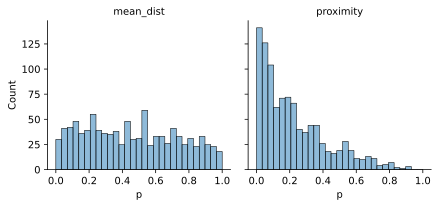

In [61]:
g = sns.FacetGrid(data=df, col='test',
                  margin_titles=True, col_wrap=3)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map(sns.histplot, 'p', alpha=0.5, bins=np.linspace(0, 1, 30)) ;

In [10]:
for _ in trange(50):
    qury_rand, annot_rand = random_intervals(chrom_len, n_segments, segment_len)
    qury_nonrand, annot_nonrand = non_random_intervals(chrom_len, n_segments, segment_len)

    #######################
    query_rand = interval_diff(qury_rand, annot_rand)
    qury_nonrand = interval_diff(qury_nonrand, annot_nonrand)
    #######################

    records.append((*mean_dist_test(qury_rand, annot_rand), 'mean', 'random'))
    records.append((*mean_dist_test(qury_nonrand, annot_nonrand), 'mean', 'non_random'))

    records.append((*median_dist_test(qury_rand, annot_rand), 'median', 'random'))
    records.append((*median_dist_test(qury_nonrand, annot_nonrand), 'median', 'non_random'))

    records.append((*proximity(qury_rand, annot_rand), 'proximity', 'random'))
    records.append((*proximity(qury_nonrand, annot_nonrand), 'proximity', 'non_random'))

    # records.append((*proximity(qury_rand, annot_rand, overlap_as_zero=True), 'proximity_ovl', 'random'))
    # records.append((*proximity(qury_nonrand, annot_nonrand, overlap_as_zero=True), 'proximity_ovl', 'non_random'))

    # records.append((*proximity(qury_rand, annot_rand, overlap_as_zero=True, span_as_zero=True), 'proximity_ovl_span', 'random'))
    # records.append((*proximity(qury_nonrand, annot_nonrand, overlap_as_zero=True, span_as_zero=True), 'proximity_ovl_span', 'non_random'))


  0%|          | 0/50 [00:00<?, ?it/s]

p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.
Process ForkPoolWorker-672:
Process ForkPoolWorker-670:
Process ForkPoolWorker-669:
Process ForkPoolWorker-667:
Process ForkPoolWorker-668:
Process ForkPoolWorker-671:
Process ForkPoolWorker-666:
Proc

KeyboardInterrupt: 

In [23]:
# df['A'] = np.floor(pd.to_numeric(df['A'], errors='coerce')).astype('Int64')

In [9]:
chrom_len, n_segments, segment_len = 150_000_000, 20, 1_000_000

qury_rand, annot_rand = random_intervals(chrom_len, n_segments, segment_len)
qury_nonrand, annot_nonrand = non_random_intervals(chrom_len, n_segments, segment_len)

query_rand = interval_diff(qury_rand, annot_rand)
qury_nonrand = interval_diff(qury_nonrand, annot_nonrand)

print(proximity(qury_rand, annot_rand))
print(proximity(qury_nonrand, annot_nonrand))
# print()
# print(proximity(qury_rand, annot_rand, overlap_as_zero=True))
# print(proximity(qury_nonrand, annot_nonrand, overlap_as_zero=True))
# print()
# print(proximity(qury_rand, annot_rand, overlap_as_zero=True, span_as_zero=True))
# print(proximity(qury_nonrand, annot_nonrand, overlap_as_zero=True, span_as_zero=True))

(-0.0786363636363636, 0.2396)
(0.21272727272727268, 0.0)



p-value is zero smaller than 0.0001. Increase nr samples to get actual p-value.


(0.06350000000000004, 0.7925)
(0.21272727272727268, 0.0369)

(0.06350000000000004, 0.7942)
(0.21272727272727268, 0.0351)


In [13]:
df = pd.DataFrame().from_records(records, columns=['stat', 'p', 'test', 'sim'])
df.head(20)

,stat,p,test,sim
0,0.254169,0.5146,mean,random
1,0.376693,0.0019,mean,non_random
2,0.224988,0.6870,median,random
3,0.500000,0.0000,median,non_random
4,-0.168522,0.4428,proximity,random
5,0.253316,0.0000,proximity,non_random
6,0.260876,0.5612,mean,random
7,0.363096,0.0142,mean,non_random
8,0.274982,0.4672,median,random
9,0.428856,0.0072,median,non_random


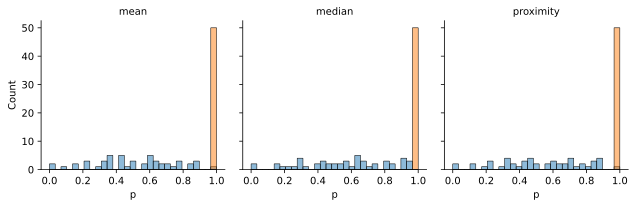

In [25]:
g = sns.FacetGrid(data=df, col='test', hue='sim',
                  margin_titles=True, col_wrap=3)
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map(sns.histplot, 'p', alpha=0.5, bins=np.linspace(0, 1, 30)) ;

### Bootstrap version of prox stat

In [166]:
distances = [0]*10 + (np.random.random(10) / 2).tolist()
distances

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.02193964134826848,
 0.2124934790697089,
 0.058496029276159434,
 0.39914885762443414,
 0.12345490605741777,
 0.21549509399313782,
 0.053310825336760626,
 0.11998196741494693,
 0.19420527365622364,
 0.3204497919119886]

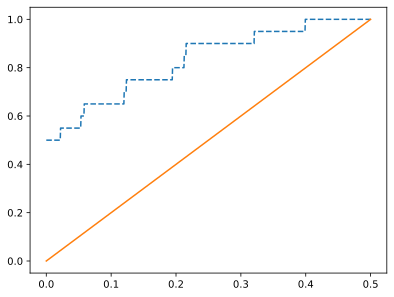

In [181]:
# ecdf = ECDF(distances, side='left')
# plt.plot(ecdf(np.linspace(0, 0.5, 200)))
ecdf = ECDF(distances, side='right')
points = np.linspace(0, 0.5, 1000)
plt.plot(points, ecdf(points), linestyle='dashed')
plt.plot(points, 2 * points)

In [187]:
from statsmodels.distributions.empirical_distribution import ECDF

@bootstrap('hg38', cores=8, samples=1000)
def proximity(q, a):
    remapped_df = remap_interval_data(q, a,                                       
                                      relative=True,
                                      overlap_as_zero=False,
                                      span_as_zero=False)
    obs_ecdf = ECDF(remapped_df.start.abs())
    points = np.linspace(0, 0.5, num=1000)  
    test_stat = sum(obs_ecdf(points) - 2 * points) / len(points)
    return test_stat

qury_rand, annot_rand = random_intervals(chrom_len, n_segments, segment_len)
qury_nonrand, annot_nonrand = non_random_intervals(chrom_len, n_segments, segment_len)

print(proximity(qury_rand, annot_rand))
print(proximity(qury_nonrand, annot_nonrand))

(-0.08369999999999987, 0.901)
(0.3309000000000001, 0.0)


p-value is zero smaller than 0.001. Increase nr samples to get actual p-value.


### Relatative distances

In [26]:
chrom_len = 10_000_000
df_list = []
for n_segments in [1000]:
    for segment_len in [10, 1000, 5000]:
        query, annot = random_intervals(chrom_len, n_segments, segment_len)

        # query = interval_diff(query, annot)
        
        _df = remap_interval_data(query, annot, relative=True)
        _df['chrom_len'] = chrom_len
        _df['segment_len'] = segment_len
        _df['n_segments'] = n_segments
        _df['mid'] = (_df.start + _df.end) / 2
        _df['absmid'] = _df.mid.abs()
        _df['absstart'] = _df.start.abs()
        df_list.append(_df)
df1 = pd.concat(df_list)        

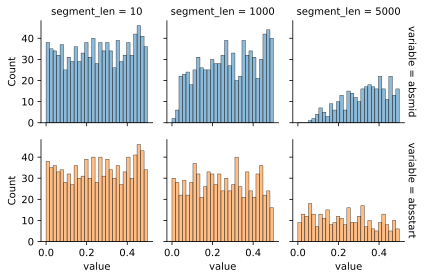

In [27]:
plot_df1 = (df1[['segment_len', 'absmid', 'absstart']]
           .melt(id_vars=['segment_len'])
          )
g = sns.FacetGrid(data=plot_df1, col='segment_len', row='variable', hue='variable',
                  margin_titles=True, height=2)
# g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map(sns.histplot, 'value', alpha=0.5, bins=np.linspace(0, 0.5, 30)) ;

In [28]:
chrom_len = 10_000_000
df_list = []
for n_segments in [1000]:
    for segment_len in [10, 1000, 5000]:
        query, annot = random_intervals(chrom_len, n_segments, segment_len)

        query = interval_diff(query, annot)
        
        _df = remap_interval_data(query, annot, relative=True)
        _df['chrom_len'] = chrom_len
        _df['segment_len'] = segment_len
        _df['n_segments'] = n_segments
        _df['mid'] = (_df.start + _df.end) / 2
        _df['absmid'] = _df.mid.abs()
        _df['absstart'] = _df.start.abs()
        df_list.append(_df)

df2 = pd.concat(df_list)

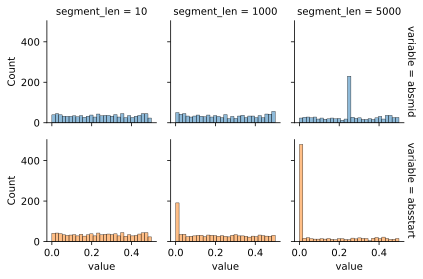

In [29]:
plot_df2 = (df2[['segment_len', 'absmid', 'absstart']]
           .melt(id_vars=['segment_len'])
          )
g = sns.FacetGrid(data=plot_df2, col='segment_len', row='variable', hue='variable',
                   margin_titles=True, height=2)
# g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.map(sns.histplot, 'value', alpha=0.5, bins=np.linspace(0, 0.5, 30)) ;

### P-value distributions

In [30]:
records = []
overlap_as_zero = False
span_as_zero = False

In [64]:
chrom_len = 10_000_000
df_list = []
bootstraps = 100
for _ in range(100):
    for n_segments in [1000]:
        # for segment_len in [1, 100, 500]:
        for segment_len in [10]:
            query, annot = random_intervals(chrom_len, n_segments, segment_len)
            records.append((*proximity_test(
                query, annot, samples=bootstraps,
                overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, 
                cores=8), 
                bootstraps, overlap_as_zero, span_as_zero))


In [65]:
df = pd.DataFrame().from_records(records, columns=['stat', 'p', 'bootstraps', 'overlap_as_zero', 'span_as_zero'])
df.head()        

,stat,p,bootstraps,overlap_as_zero,span_as_zero
0,0.002827,0.2560,10000,False,False
1,-0.002685,0.1405,10000,False,False
2,-0.001753,0.1377,10000,False,False
3,-0.010226,0.7150,10000,False,False
4,-0.002436,0.3350,10000,False,False


<Axes: xlabel='stat', ylabel='p'>

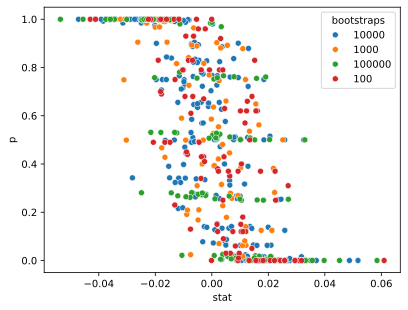

In [66]:
plot_df = df.loc[~df.overlap_as_zero & ~df.span_as_zero]
plot_df['bootstraps'] = plot_df.bootstraps.astype(str)
sns.scatterplot(plot_df, x='stat', y='p', hue='bootstraps')

<Axes: xlabel='p', ylabel='Count'>

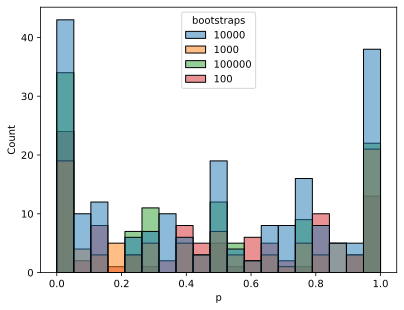

In [70]:
sns.histplot(plot_df, x='p', hue='bootstraps', bins=np.linspace(0, 1, 20)) ;

# Looks like *fewer* bootraps gives a more uniform pval dist

<Axes: xlabel='p', ylabel='Count'>

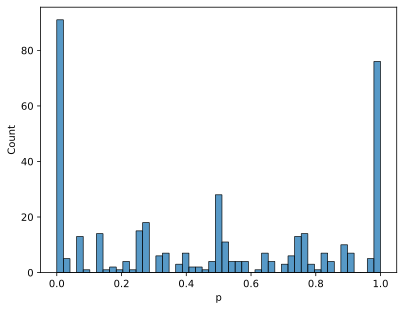

In [58]:
sns.histplot(plot_df, x='p', bins=np.linspace(0, 1, 50))

In [34]:
from genominterv.intervals import interval_diff
records_non_ovl = []
overlap_as_zero = False
span_as_zero = False
n = 10

In [36]:
for _ in range(1000):
    a = np.sort(np.random.randint(1, 10_000_000, size=n))
    annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
    q = np.sort(np.random.randint(1, 10_000_000, size=n))
    query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
    annot = interval_collapse(annot)
    query = interval_collapse(query)    
    non_ovl_query = interval_diff(query, annot)
    records_non_ovl.append((*proximity_test(
        query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8), 
                   overlap_as_zero, span_as_zero))

In [37]:
df_non_ovl = pd.DataFrame().from_records(records_non_ovl, columns=['stat', 'p', 'overlap_as_zero', 'span_as_zero'])
df_non_ovl.head() 

,stat,p,overlap_as_zero,span_as_zero
0,0.1586,0.0000,False,False
1,0.1620,0.0001,False,False
2,-0.1540,0.8722,False,False
3,0.3576,0.0000,False,False
4,0.2124,0.0000,False,False


<Axes: xlabel='p', ylabel='Count'>

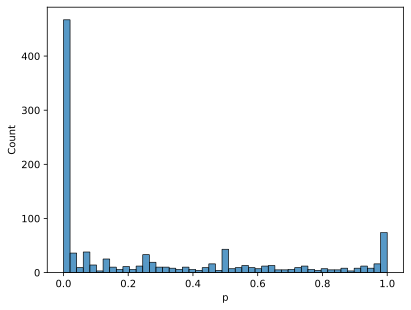

In [38]:
sns.histplot(df_non_ovl, x='p', bins=np.linspace(0, 1, 50))

-----

In [8]:
from genominterv.intervals import interval_diff

non_ovl_query = interval_diff(query, annot)
non_ovl_query

,start,end,chrom
0,41000000,40500000,chr1
1,105000000,106000000,chr1
2,170000000,173000000,chr1


In [10]:
import seaborn as sns
from genominterv.intervals import interval_diff

records = []
for overlap_as_zero in [False, True]:
    for span_as_zero in [False, True]:
        n = 1000
        a = np.sort(np.random.randint(1, 10_000_000, size=n))
        annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
        q = np.sort(np.random.randint(1, 10_000_000, size=n))
        query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
        non_ovl_query = interval_diff(query, annot)
        records.append(('random', 'full', overlap_as_zero, span_as_zero, *proximity_test(
            query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        records.append(('random', 'nonovl', overlap_as_zero, span_as_zero, *proximity_test(
            non_ovl_query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        
        a = np.sort(np.random.randint(1, 10_000_000, size=n))
        annot = pd.DataFrame(dict(chrom='chrX', start=a, end=a+10))
        q = a + np.random.randint(-1000, 1000, size=n)
        query = pd.DataFrame(dict(chrom='chrX', start=q, end=q+10))
        non_ovl_query = interval_diff(query, annot)
        records.append(('non-random', 'full', overlap_as_zero, span_as_zero, *proximity_test(
            query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        records.append(('non-random', 'non-ovl', overlap_as_zero, span_as_zero, *proximity_test(
            non_ovl_query, annot, overlap_as_zero=overlap_as_zero, span_as_zero=span_as_zero, cores=8)))
        
df = pd.DataFrame().from_records(records, columns=['query', 'subset', 'overlap_as_zero', 'span_as_zero', 'stat', 'p'])
df['-log10p'] = -np.log10(df.p)
df

/Users/kmt/miniconda3/envs/condabuild/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,0.017866,0.2050,0.688246
1,random,nonovl,False,False,0.019826,0.1259,0.899974
2,non-random,full,False,False,0.610130,0.0000,inf
3,non-random,non-ovl,False,False,0.616401,0.0000,inf
4,random,full,False,True,0.032529,0.0000,inf
5,random,nonovl,False,True,0.033496,0.0000,inf
6,non-random,full,False,True,0.572356,0.0000,inf
7,non-random,non-ovl,False,True,0.576616,0.0000,inf
8,random,full,True,False,0.006355,0.8847,0.053204
9,random,nonovl,True,False,0.006355,0.8847,0.053204


In [11]:
df.loc[df.span_as_zero == False].sort_values(by='query')

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
2,non-random,full,False,False,0.610130,0.0000,inf
3,non-random,non-ovl,False,False,0.616401,0.0000,inf
10,non-random,full,True,False,0.614519,0.0000,inf
11,non-random,non-ovl,True,False,0.614519,0.0000,inf
0,random,full,False,False,0.017866,0.2050,0.688246
1,random,nonovl,False,False,0.019826,0.1259,0.899974
8,random,full,True,False,0.006355,0.8847,0.053204
9,random,nonovl,True,False,0.006355,0.8847,0.053204


In [12]:
(df.style
 .background_gradient(subset='p', cmap='Reds', vmin=0, vmax=1)
 .background_gradient(subset='stat', cmap='Blues')
)


,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,0.017866,0.205000,0.688246
1,random,nonovl,False,False,0.019826,0.125900,0.899974
2,non-random,full,False,False,0.610130,0.000000,inf
3,non-random,non-ovl,False,False,0.616401,0.000000,inf
4,random,full,False,True,0.032529,0.000000,inf
5,random,nonovl,False,True,0.033496,0.000000,inf
6,non-random,full,False,True,0.572356,0.000000,inf
7,non-random,non-ovl,False,True,0.576616,0.000000,inf
8,random,full,True,False,0.006355,0.884700,0.053204
9,random,nonovl,True,False,0.006355,0.884700,0.053204


In [17]:
def condition(v):
    if v == False:
        return "Dry"
    else:
        return "Rain"
    
def make_pretty(styler):
    # styler.set_caption("Weather Conditions")
    # styler.format(condition)
    # styler.format_index(lambda v: v.strftime("%A"))
    styler.background_gradient(axis=None, vmin=0, vmax=3, cmap="Reds")
    return styler

In [19]:
s = df.loc[df.span_as_zero == False].sort_values(by='query').style.pipe(make_pretty)
# s = df.style.pipe(make_pretty)
s

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
2,non-random,full,False,False,0.599101,0.000000,inf
3,non-random,non-ovl,False,False,0.603118,0.000000,inf
10,non-random,full,True,False,0.574230,0.000000,inf
11,non-random,non-ovl,True,False,0.574230,0.000000,inf
0,random,full,False,False,0.020704,0.125000,0.903090
1,random,nonovl,False,False,0.023642,0.000500,3.301030
8,random,full,True,False,0.021538,0.000200,3.698970
9,random,nonovl,True,False,0.021538,0.095600,1.019542


In [65]:
def highlight_max(s, props=''):
    return np.where(s == False, props, '')
s.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)

,query,subset,overlap_as_zero,span_as_zero,stat,p,-log10p
0,random,full,False,False,-0.020317,1.000000,-0.000000
1,random,nonovl,False,False,-0.019295,0.374400,0.426664
2,random,full,False,False,0.616193,0.000000,inf
3,random,non-ovl,False,False,0.621944,0.000000,inf
4,random,full,False,True,-0.003482,0.296100,0.528562
5,random,nonovl,False,True,-0.002480,0.679800,0.167619
6,random,full,False,True,0.610937,0.000000,inf
7,random,non-ovl,False,True,0.613264,0.000000,inf
8,random,full,True,False,0.007992,0.039300,1.405607
9,random,nonovl,True,False,0.007992,0.251900,0.598772


In [ ]:
def highlight_max(s, props=''):
    return np.where(s == np.nanmax(s.values), props, '')
s2.apply(highlight_max, props='color:white;background-color:darkblue', axis=0)